Fitting estimator with 44 features.
Fitting estimator with 43 features.
Optimal number of features: 42
|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9297    | 0.1186    | 9.655     | 233.0     |
| 2         | 0.9203    | 0.1836    | 4.092     | 89.0      |
| 3         | 0.9068    | 0.02684   | 9.063     | 200.3     |
| 4         | 0.923     | 0.2153    | 3.144     | 292.5     |
| 5         | 0.9176    | 0.2514    | 4.486     | 95.46     |
| 6         | 0.9203    | 0.06319   | 5.13      | 181.2     |
| 7         | 0.9257    | 0.1353    | 5.039     | 203.0     |
| 8         | 0.9176    | 0.05045   | 5.045     | 141.6     |
| 9         | 0.9176    | 0.1423    | 8.496     | 99.92     |
| 10        | 0.9257    | 0.1591    | 7.147     | 61.61     |
| 11        | 0.9176    | 0.2369    | 3.161     | 292.4     |
| 12        | 0.9054    | 0.05663   | 5.793     | 71.63     |
| 13        | 0.9243    | 0.1

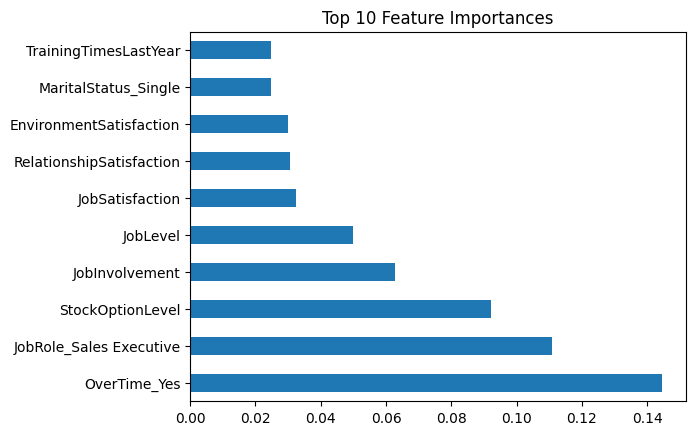

In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization  # For Bayesian Hyperparameter Optimization
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
drop_columns = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df = df.drop(drop_columns, axis=1)

low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=low_variance_cols)

categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
                'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X = df.drop(columns=['Attrition'])
y = LabelEncoder().fit_transform(df['Attrition'])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)

X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)
print(f"Optimal number of features: {rfecv.n_features_}")

def xgb_evaluate(max_depth, learning_rate, n_estimators):
    xgb = XGBClassifier(max_depth=int(max_depth), 
                        learning_rate=learning_rate,
                        n_estimators=int(n_estimators),
                        random_state=42,
                        eval_metric='logloss')
    xgb.fit(X_train_rfe, y_train)
    predictions = xgb.predict(X_test_rfe)
    return accuracy_score(y_test, predictions)

xgb_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300)
}

xgb_optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=xgb_bounds, random_state=42, verbose=2)
xgb_optimizer.maximize(init_points=10, n_iter=30)

best_params = xgb_optimizer.max['params']
best_xgb = XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    random_state=42,
    eval_metric='logloss'
)
best_xgb.fit(X_train_rfe, y_train)

y_pred = best_xgb.predict(X_test_rfe)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns[rfecv.support_])
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()
